# 波动率溢出效应

In [1]:
import warnings

# 关闭所有警告
warnings.filterwarnings("ignore")

# 你可以在此处放置你的代码
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') 
plt.rcParams['font.sans-serif'] = 'Songti SC'  # 设置字体为SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决负号“-”显示异常

from importlib import reload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def compute_spillover_matrix(s):
    spillover_matrix = {}
    for i in  df.columns:
        spillover_matrix[i] = {}
        for j in s.index:
            if '->' not in j: continue
            if j.split('->')[1] == i:
                spillover_matrix[j.split('->')[1]][j.split('->')[0]] = s[j]
    return pd.DataFrame(spillover_matrix).abs()

In [3]:
def stat_spillover_matrix(spillover_matrix):
    s_df = pd.DataFrame(spillover_matrix).abs()
    df_no_diag = s_df.mask(np.eye(s_df.shape[0], dtype=bool))
    sum_1 = df_no_diag.sum(axis=1)
    sum_1.name = '溢入'
    sum_0 = df_no_diag.sum(axis=0)
    sum_0.name = '溢出'
    net = sum_0 - sum_1
    
    s_df2 = pd.concat([s_df, pd.DataFrame(sum_0, columns=['溢出']).T], axis=0)
    s_df3 = pd.concat([s_df2, pd.DataFrame(net, columns=['净溢出']).T], axis=0)
    sum_ = sum_1.to_dict()
    sum_['溢出'] = sum_0.sum()
    sum_['净溢出'] = 0.
    s_df4 = pd.concat([s_df3, pd.DataFrame({"溢入":sum_})], axis=1)
    return s_df4

## 传统能源和绿色能源市场的静态溢出指数

In [4]:
df = pd.read_csv('datasets/garch_volatility_df.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df= df.drop(['Geopolitics', 'Climate Policy'], axis=1)
df.shape, df.dropna(axis=1).shape

((1402, 6), (1402, 6))

In [5]:
from tvpvar import TVPVAR
mod = TVPVAR(df)

/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [6]:
initial_obs_cov = np.cov(df.T)
initial_state_cov_diag = [0.01] * mod.k_states

# Update H and Q
mod.update_variances(initial_obs_cov, initial_state_cov_diag)
initial_res = mod.smooth([])
initial_res.states.filtered.columns = [i.replace('L1.', '') for i in initial_res.states.filtered.columns]
initial_res.states.filtered.index = df.index[1:]


/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:2997: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'
/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:2997: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'
/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:2997: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'


In [7]:
s = initial_res.states.filtered.mean()
spillover_matrix =compute_spillover_matrix(s)
spillover_matrix = stat_spillover_matrix(spillover_matrix)
spillover_matrix.round(3)

/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:2997: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'


,New Energy,Green Bond,Carbon Price,Crude Oil,Natural Gas,Coke,溢入
New Energy,0.018,0.001,0.095,0.054,0.061,0.004,0.215
Green Bond,0.001,0.000,0.006,0.001,0.005,0.011,0.024
Carbon Price,0.004,0.001,0.177,0.004,0.013,0.033,0.055
Crude Oil,0.001,0.000,0.017,0.005,0.007,0.026,0.051
Natural Gas,0.003,0.000,0.096,0.015,0.014,0.004,0.119
Coke,0.000,0.000,0.004,0.014,0.009,0.217,0.027
溢出,0.009,0.003,0.218,0.088,0.094,0.079,0.491
净溢出,-0.206,-0.022,0.163,0.037,-0.025,0.052,0.000


## 地缘政治风险、气候政策风险、传统能源和绿色市场之间的静态溢出指数

In [8]:
df = pd.read_csv('datasets/garch_volatility_df.csv', index_col=0)
df.index = pd.to_datetime(df.index)
#df = df.iloc[:,2:]

In [9]:
df.shape, df.dropna(axis=1).shape

((1402, 8), (1402, 8))

In [10]:
from tvpvar import TVPVAR# Create an instance of our TVPVAR class with our observed dataset y
mod = TVPVAR(df)

/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [11]:
initial_obs_cov = np.cov(df.T)
initial_state_cov_diag = [0.01] * mod.k_states

# Update H and Q
mod.update_variances(initial_obs_cov, initial_state_cov_diag)
initial_res = mod.smooth([])
initial_res.states.filtered.columns = [i.replace('L1.', '') for i in initial_res.states.filtered.columns]
initial_res.states.filtered.index = df.index[1:]


/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:2997: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'
/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:2997: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'
/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:2997: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'


In [12]:
s = initial_res.states.filtered.mean()
spillover_matrix =compute_spillover_matrix(s)

/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:2997: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'


In [13]:
net_spillover_matrix = stat_spillover_matrix(spillover_matrix)
net_spillover_matrix.round(3)

,Geopolitics,Climate Policy,New Energy,Green Bond,Carbon Price,Crude Oil,Natural Gas,Coke,溢入
Geopolitics,0.565,0.018,0.001,0.000,0.001,0.008,0.003,0.000,0.030
Climate Policy,0.005,0.398,0.000,0.000,0.005,0.002,0.002,0.001,0.015
New Energy,0.130,0.280,0.014,0.001,0.070,0.046,0.043,0.029,0.599
Green Bond,0.019,0.008,0.000,0.000,0.009,0.001,0.001,0.010,0.049
Carbon Price,0.174,0.383,0.004,0.001,0.174,0.003,0.021,0.027,0.612
Crude Oil,0.372,0.254,0.000,0.000,0.035,0.015,0.020,0.027,0.709
Natural Gas,0.174,0.128,0.004,0.000,0.083,0.014,0.012,0.008,0.411
Coke,0.056,0.334,0.000,0.000,0.001,0.014,0.008,0.207,0.413
溢出,0.929,1.405,0.009,0.003,0.203,0.088,0.097,0.102,2.837
净溢出,0.899,1.390,-0.590,-0.046,-0.409,-0.621,-0.314,-0.310,0.000


## 净溢出效应

/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:2997: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'


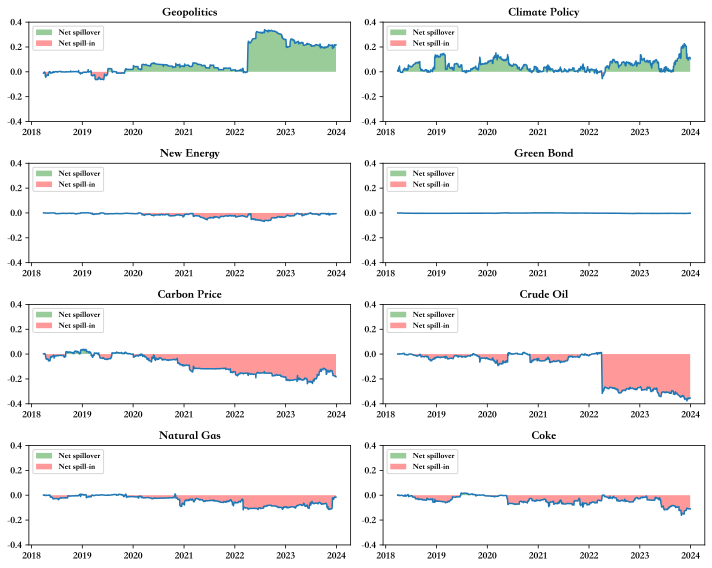

In [14]:
spillover = pd.DataFrame(initial_res.states.filtered)
fig, axes = plt.subplots(4, 2, figsize=(10, 8))
ax = axes.ravel()
ax_num = 0
for i in df.columns:
    #print(i)
    receive_df, send_df = pd.DataFrame(), pd.DataFrame()
    for j in spillover.columns:
        if '->%s' %i in j and '%s->%s' %(i,i) not in j:   # receive
            send_df = pd.concat([send_df, spillover[j]], axis=1)
        elif '%s->' %i in j and '%s->%s' %(i,i) not in j:  # send
            receive_df = pd.concat([receive_df, spillover[j]], axis=1)
    x = receive_df.index
    y = send_df.mean(axis=1).abs() - receive_df.mean(axis=1).abs()
    ax[ax_num].plot(x, y)
    ax[ax_num].fill_between(x, y, 0, where=(y > 0), facecolor='green', alpha=0.4, interpolate=True, label='Net spillover')
    ax[ax_num].fill_between(x, y, 0, where=(y <= 0), facecolor='red', alpha=0.4, interpolate=True, label='Net spill-in')


    # 修改图例框的样式为直角
    ax[ax_num].legend(prop={'size': 8}, loc='upper left')
    # legend = ax[ax_num].legend()
    # frame = legend.get_frame()
    # frame.set_edgecolor('black')  # 设置边框颜色
    # frame.set_linewidth(1)         # 设置边框宽度
    # frame.set_facecolor('white')   # 设置背景颜色
    # frame.set_alpha(1)             # 设置透明度（1为不透明）
    ax[ax_num].set_ylim([-0.4, 0.4])
    ax[ax_num].set_title(i)
    ax_num += 1
plt.tight_layout()
plt.savefig('images/波动净溢出.svg')

## 俄乌战争

In [22]:
def compute_net_spillover_matrix(spillover_matrix_df):
    spillover_matrix = spillover_matrix_df.to_dict()
    net_spillover_matrix = {}
    for i in spillover_matrix:
        net_spillover_matrix[i] = {}
        for j in spillover_matrix[i]:
            if abs(spillover_matrix[i][j]) - abs(spillover_matrix[j][i]) > 0:
                net_spillover_matrix[i][j] = abs(spillover_matrix[i][j]) - abs(spillover_matrix[j][i])
            elif abs(spillover_matrix[i][j]) - abs(spillover_matrix[j][i]) == 0:
                net_spillover_matrix[i][j] = abs(spillover_matrix[i][j])
            else:
                net_spillover_matrix[i][j] = 0
            #print(i, j, spillover_matrix[i][j] , spillover_matrix[j][i] )
    return pd.DataFrame(net_spillover_matrix)#.abs()

In [43]:
date='2023-12-29'
s = initial_res.states.filtered.loc[date]
spillover_matrix_df = compute_spillover_matrix(s)
net_spillover_matrix = compute_net_spillover_matrix(spillover_matrix_df)
net_spillover_matrix.to_csv('datasets/俄乌冲突：%s.csv' %date)

/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:2997: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'


In [24]:
net_spillover_matrix

,Geopolitics,Climate Policy,New Energy,Green Bond,Carbon Price,Crude Oil,Natural Gas,Coke
Geopolitics,0.583603,0.097926,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Climate Policy,0.000000,0.233983,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
New Energy,0.309515,0.647089,0.036696,0.000941,0.106311,0.035629,0.095077,0.030541
Green Bond,0.025940,0.003369,0.000000,0.000111,0.014336,0.001552,0.002332,0.039684
Carbon Price,0.231883,0.937844,0.000000,0.000000,0.249648,0.000000,0.064879,0.073808
Crude Oil,1.508239,0.426495,0.000000,0.000000,0.054577,0.057023,0.000000,0.016199
Natural Gas,0.478636,0.221005,0.000000,0.000000,0.000000,0.013082,0.066990,0.033538
Coke,0.153051,0.514365,0.000000,0.000000,0.000000,0.000000,0.000000,0.223298


## 气候政策

/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:2997: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'


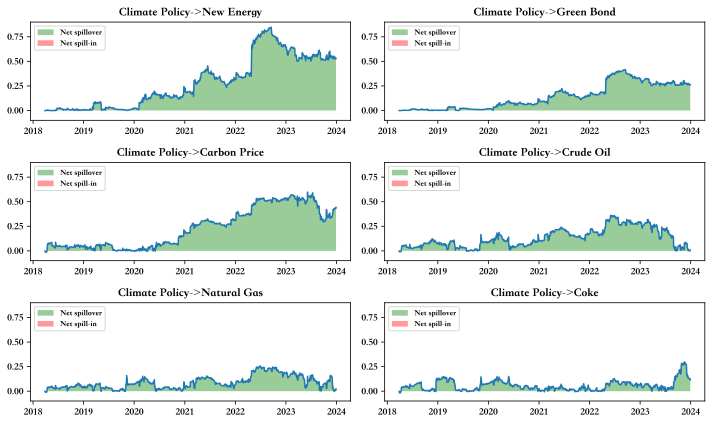

In [15]:
spillover = pd.DataFrame(initial_res.states.filtered)
fig, axes = plt.subplots(3, 2, figsize=(10, 6))
ax = axes.ravel()
ax_num = 0
for i in ['Climate Policy']:
    #print(i)
    receive_df, send_df = pd.DataFrame(), pd.DataFrame()
    for j in ["New Energy","Green Bond","Carbon Price","Crude Oil","Natural Gas", "Coke"]:
        #print(i, j)
        send_df = pd.concat([send_df, spillover['%s->%s' %(i,j)]], axis=1)
        receive_df = pd.concat([receive_df, spillover['%s->%s' %(j,i)]], axis=1)
        x = receive_df.index
        y = -(send_df.mean(axis=1).abs() - receive_df.mean(axis=1).abs())
        ax[ax_num].plot(x, y)
        ax[ax_num].fill_between(x, y, 0, where=(y > 0), facecolor='green', alpha=0.4, interpolate=True, label='Net spillover')
        ax[ax_num].fill_between(x, y, 0, where=(y <= 0), facecolor='red', alpha=0.4, interpolate=True, label='Net spill-in')
        ax[ax_num].legend(prop={'size': 8}, loc='upper left')
        ax[ax_num].set_title('%s->%s' %(i,j))
        ax[ax_num].set_ylim([-0.1, 0.9])
        ax_num += 1
plt.tight_layout()
plt.savefig('images/波动气候政策.svg')